An attempt to predict the win probability of the teams in a given match at the end of each over and to look at the important factors affecting the match output.

**Objective :** 
To predict the win probability of SRH at the end of each over for the finals of IPL season 2016.

**Training data :**
All other matches played during 2016 season 

Let us first import the necessary modules.!

In [1]:
import operator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
%matplotlib inline
pd.set_option('display.max_columns', 50)

Load the dataset and look at the top few rows to get an idea about the data. 

If you want to know more about the data, please look at the kernel here

In [2]:
data_path = ""
score_df = pd.read_csv(data_path+"deliveries.csv")
match_df = pd.read_csv(data_path+"matches.csv")
score_df.head()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,4,0,4,NaN,NaN,NaN
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,2,0,0,0,0,0,2,2,NaN,NaN,NaN


In this analysis, we are going to look at the matches played only during the latest season 2016. So let us subset the dataset to get only these rows. 

Also some matches are affected by rain and hence Duckworth-Lewis method are used for these matches and so using these matches for training our model might cause some error in our training and so let us neglect those matches as well.

In [3]:
match_df['season'].unique()

array([2017, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2018,
       2019], dtype=int64)

In [4]:
# Let us take only the matches played in 2016 for this analysis #
match_df = match_df.loc[match_df.season==2019,:]
match_df = match_df.loc[match_df.dl_applied == 0,:]
match_df.head()

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
696,11137,2019,Chennai,23/03/19,Royal Challengers Bangalore,Chennai Super Kings,Chennai Super Kings,field,normal,0,Chennai Super Kings,0,7,Harbhajan Singh,M. A. Chidambaram Stadium,Bruce Oxenford,Anil Dandekar,Nitin Menon
697,11138,2019,Kolkata,24/03/19,Sunrisers Hyderabad,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,6,AD Russell,Eden Gardens,Chris Gaffaney,Anil Chaudhary,Vineet Kulkarni
698,11139,2019,Mumbai,24/03/19,Delhi Capitals,Mumbai Indians,Mumbai Indians,field,normal,0,Delhi Capitals,37,0,RR Pant,Wankhede Stadium,S Ravi,Yeshwant Barde,O Nandan
699,11140,2019,Jaipur,25/03/19,Kings XI Punjab,Rajasthan Royals,Rajasthan Royals,field,normal,0,Kings XI Punjab,14,0,CH Gayle,Sawai Mansingh Stadium,C Shamshuddin,KN Anantapadmanabhan,Bruce Oxenford
700,11141,2019,Delhi,26/03/19,Delhi Capitals,Chennai Super Kings,Delhi Capitals,bat,normal,0,Chennai Super Kings,0,6,SR Watson,Feroz Shah Kotla Ground,Marais Erasmus,Nitin Menon,Anil Dandekar


Okay. Now that we are done with the pre-processing, let us create the variables that are needed for building our model. 

Some of the important variables which I could think of are the following:

1. Runs scored in the last over
2. Wickets taken in the last over
3. Total score of the innings
4. Total wickets 
5. Target that the team is chasing down
6. Remaining target
7. Run rate
8. Required run rate
9. Difference between run rate and required run rate
10. Binary variables on whether the team for which we are predicting is batting team or bowling team

There are several other variables which we can create including

1. Team name
2. Opponent team name
3. Score in the last 'n' overs
4. Players who are batting
5. Player who is bowling and so on.

But ours is a good set of variables to start with.



In [5]:
# runs and wickets per over #
score_df = pd.merge(score_df, match_df[['id','season','city','toss_decision','toss_winner','venue','winner', 'result', 'dl_applied', 'team1', 'team2']], left_on='match_id', right_on='id')
score_df.player_dismissed.fillna(0, inplace=True)
score_df['player_dismissed'].loc[score_df['player_dismissed'] != 0] = 1
train_df = score_df.groupby(['match_id','city','inning','toss_decision','toss_winner','venue','over', 'team1', 'team2', 'batting_team', 'winner'])[['total_runs', 'player_dismissed']].agg(['sum']).reset_index()
train_df.columns = train_df.columns.get_level_values(0)

# innings score and wickets #

train_df['player_dismissed'] = train_df['player_dismissed'].astype('int')
train_df['innings_wickets'] = train_df.groupby(['match_id', 'inning'])['player_dismissed'].cumsum()
train_df['innings_score'] = train_df.groupby(['match_id', 'inning'])['total_runs'].cumsum()
train_df.head()

# Get the target column #
temp_df = train_df.groupby(['match_id', 'inning'])['total_runs'].sum().reset_index()
temp_df = temp_df.loc[temp_df['inning']==1,:]
temp_df['inning'] = 2
temp_df.columns = ['match_id', 'inning', 'score_target']
train_df = train_df.merge(temp_df, how='left', on = ['match_id', 'inning'])
train_df['score_target'].fillna(-1, inplace=True)

# get the remaining target #
def get_remaining_target(row):
    if row['score_target'] == -1.:
        return -1
    else:
        return row['score_target'] - row['innings_score']

train_df['remaining_target'] = train_df.apply(lambda row: get_remaining_target(row),axis=1)

# get the run rate #
train_df['run_rate'] = train_df['innings_score'] / train_df['over']

# get the remaining run rate #
def get_required_rr(row):
    if row['remaining_target'] == -1:
        return -1.
    elif row['over'] == 20:
        return 99
    else:
        return row['remaining_target'] / (20-row['over'])
    
train_df['required_run_rate'] = train_df.apply(lambda row: get_required_rr(row), axis=1)

def get_rr_diff(row):
    if row['inning'] == 1:
        return -1
    else:
        return row['run_rate'] - row['required_run_rate']
    
train_df['runrate_diff'] = train_df.apply(lambda row: get_rr_diff(row), axis=1)
train_df['is_batting_team'] = (train_df['team1'] == train_df['batting_team']).astype('int')
train_df['target'] = (train_df['team1'] == train_df['winner']).astype('int')

train_df.head()

C:\Users\majumder_souptik@lilly.com\AppData\Local\Temp\ipykernel_26716\3062254405.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_df['player_dismissed'].loc[score_df['player_dismissed'] != 0] = 1


,match_id,city,inning,toss_decision,toss_winner,venue,over,team1,team2,batting_team,winner,total_runs,player_dismissed,innings_wickets,innings_score,score_target,remaining_target,run_rate,required_run_rate,runrate_diff,is_batting_team,target
0,11137,Chennai,1,field,Chennai Super Kings,M. A. Chidambaram Stadium,1,Royal Challengers Bangalore,Chennai Super Kings,Royal Challengers Bangalore,Chennai Super Kings,5,0,0,5,-1.0,-1.0,5.000000,-1.0,-1.0,1,0
1,11137,Chennai,1,field,Chennai Super Kings,M. A. Chidambaram Stadium,2,Royal Challengers Bangalore,Chennai Super Kings,Royal Challengers Bangalore,Chennai Super Kings,8,0,0,13,-1.0,-1.0,6.500000,-1.0,-1.0,1,0
2,11137,Chennai,1,field,Chennai Super Kings,M. A. Chidambaram Stadium,3,Royal Challengers Bangalore,Chennai Super Kings,Royal Challengers Bangalore,Chennai Super Kings,4,0,0,17,-1.0,-1.0,5.666667,-1.0,-1.0,1,0
3,11137,Chennai,1,field,Chennai Super Kings,M. A. Chidambaram Stadium,4,Royal Challengers Bangalore,Chennai Super Kings,Royal Challengers Bangalore,Chennai Super Kings,7,1,1,24,-1.0,-1.0,6.000000,-1.0,-1.0,1,0
4,11137,Chennai,1,field,Chennai Super Kings,M. A. Chidambaram Stadium,5,Royal Challengers Bangalore,Chennai Super Kings,Royal Challengers Bangalore,Chennai Super Kings,6,0,1,30,-1.0,-1.0,6.000000,-1.0,-1.0,1,0


Now let us split the data and keep the final match as our validation sample.

In [6]:
train_df.city.unique()

array(['Chennai', 'Kolkata', 'Mumbai', 'Jaipur', 'Delhi', 'Bengaluru',
       'Hyderabad', 'Mohali', 'Visakhapatnam'], dtype=object)

In [7]:
train_df.venue.unique()

array(['M. A. Chidambaram Stadium', 'Eden Gardens', 'Wankhede Stadium',
       'Sawai Mansingh Stadium', 'Feroz Shah Kotla Ground',
       'M. Chinnaswamy Stadium', 'Rajiv Gandhi Intl. Cricket Stadium',
       'IS Bindra Stadium', 'ACA-VDCA Stadium'], dtype=object)

In [8]:
train_df['match_id'].unique()

array([11137, 11138, 11139, 11140, 11141, 11142, 11143, 11144, 11145,
       11146, 11147, 11148, 11149, 11150, 11151, 11152, 11153, 11309,
       11310, 11311, 11312, 11313, 11314, 11315, 11316, 11317, 11318,
       11319, 11320, 11321, 11322, 11323, 11324, 11325, 11326, 11327,
       11328, 11329, 11330, 11331, 11332, 11333, 11334, 11335, 11336,
       11337, 11338, 11339, 11341, 11342, 11343, 11344, 11345, 11346,
       11347, 11412, 11413, 11414, 11415], dtype=int64)

In [9]:
#combine city and venue in one single column#
#train_df['city_venue'] = train_df['city'].astype(str) + '_' + train_df['venue'].astype(str)
train_df.drop('venue', axis=1, inplace=True)
train_df.drop('city', axis=1, inplace=True)
#train_df.drop('city_venue', axis=1, inplace=True)

# cnvert toss decision to bat = 1 and field = 0 #
train_df['toss_decision'] = (train_df['toss_decision'] == 'bat').astype('int')
#train_df.drop('toss_decision', axis=1, inplace=True)


In [10]:
#convert categorical variables to one-hot encoded variables#
#train_df = pd.get_dummies(train_df, columns=['city_venue'])
# label encode the city and venue #
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# train_df['city'] = le.fit_transform(train_df['city'])
#train_df['venue'] = le.fit_transform(train_df['venue'])

In [11]:
train_df.head()

,match_id,inning,toss_decision,toss_winner,over,team1,team2,batting_team,winner,total_runs,player_dismissed,innings_wickets,innings_score,score_target,remaining_target,run_rate,required_run_rate,runrate_diff,is_batting_team,target
0,11137,1,0,Chennai Super Kings,1,Royal Challengers Bangalore,Chennai Super Kings,Royal Challengers Bangalore,Chennai Super Kings,5,0,0,5,-1.0,-1.0,5.000000,-1.0,-1.0,1,0
1,11137,1,0,Chennai Super Kings,2,Royal Challengers Bangalore,Chennai Super Kings,Royal Challengers Bangalore,Chennai Super Kings,8,0,0,13,-1.0,-1.0,6.500000,-1.0,-1.0,1,0
2,11137,1,0,Chennai Super Kings,3,Royal Challengers Bangalore,Chennai Super Kings,Royal Challengers Bangalore,Chennai Super Kings,4,0,0,17,-1.0,-1.0,5.666667,-1.0,-1.0,1,0
3,11137,1,0,Chennai Super Kings,4,Royal Challengers Bangalore,Chennai Super Kings,Royal Challengers Bangalore,Chennai Super Kings,7,1,1,24,-1.0,-1.0,6.000000,-1.0,-1.0,1,0
4,11137,1,0,Chennai Super Kings,5,Royal Challengers Bangalore,Chennai Super Kings,Royal Challengers Bangalore,Chennai Super Kings,6,0,1,30,-1.0,-1.0,6.000000,-1.0,-1.0,1,0


In [12]:
# set xcols to all columns except the ones in remove_cols
x_cols = [x for x in train_df.columns if x not in ['match_id','venue','city','toss_winner','team1', 'team2', 'batting_team', 'winner', 'target']]

print(x_cols)
print(len(x_cols))

# let us take all the matches but for the final as development sample and final as val sample #
val_df = train_df.loc[train_df.match_id == 11415,:]
dev_df = train_df.loc[train_df.match_id != 11415,:]

# create the input and target variables #
dev_X = np.array(dev_df[x_cols[:]])
dev_y = np.array(dev_df['target'])
val_X = np.array(val_df[x_cols[:]])[:-1,:]
val_y = np.array(val_df['target'])[:-1]
print(dev_X.shape, dev_y.shape)
print(val_X.shape, val_y.shape)

['inning', 'toss_decision', 'over', 'total_runs', 'player_dismissed', 'innings_wickets', 'innings_score', 'score_target', 'remaining_target', 'run_rate', 'required_run_rate', 'runrate_diff', 'is_batting_team']
13
(2278, 13) (2278,)
(39, 13) (39,)


In [13]:
val_df.head()

,match_id,inning,toss_decision,toss_winner,over,team1,team2,batting_team,winner,total_runs,player_dismissed,innings_wickets,innings_score,score_target,remaining_target,run_rate,required_run_rate,runrate_diff,is_batting_team,target
2278,11415,1,1,Mumbai Indians,1,Mumbai Indians,Chennai Super Kings,Mumbai Indians,Mumbai Indians,2,0,0,2,-1.0,-1.0,2.000000,-1.0,-1.0,1,1
2279,11415,1,1,Mumbai Indians,2,Mumbai Indians,Chennai Super Kings,Mumbai Indians,Mumbai Indians,8,0,0,10,-1.0,-1.0,5.000000,-1.0,-1.0,1,1
2280,11415,1,1,Mumbai Indians,3,Mumbai Indians,Chennai Super Kings,Mumbai Indians,Mumbai Indians,21,0,0,31,-1.0,-1.0,10.333333,-1.0,-1.0,1,1
2281,11415,1,1,Mumbai Indians,4,Mumbai Indians,Chennai Super Kings,Mumbai Indians,Mumbai Indians,7,0,0,38,-1.0,-1.0,9.500000,-1.0,-1.0,1,1
2282,11415,1,1,Mumbai Indians,5,Mumbai Indians,Chennai Super Kings,Mumbai Indians,Mumbai Indians,8,1,1,46,-1.0,-1.0,9.200000,-1.0,-1.0,1,1


We shall use Xgboost for our modeling. Let us create a custom function for the same.

In [14]:
# define the function to create the model #
def runXGB(train_X, train_y, seed_val=0):
    param = {}
    param['objective'] = 'binary:logistic'
    param['eta'] = 0.05
    param['max_depth'] = 8
    param['silent'] = 1
    param['eval_metric'] = "auc"
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    num_rounds = 100

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)
    model = xgb.train(plst, xgtrain, num_rounds)
    return model

Now we are all set to build our model and make predictions. 

In [15]:
# let us build the model and get predcition for the final match #
model = runXGB(dev_X, dev_y)
xgtest = xgb.DMatrix(val_X)
preds = model.predict(xgtest)

[13:51:57] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.



In [16]:
preds

array([0.23164214, 0.4621921 , 0.7158908 , 0.6509528 , 0.5950105 ,
       0.45095348, 0.4503881 , 0.18326284, 0.16601941, 0.42629796,
       0.58579296, 0.6472319 , 0.30520475, 0.1575311 , 0.31285018,
       0.34809402, 0.36052758, 0.58909065, 0.28944936, 0.34113866,
       0.18628967, 0.22051163, 0.19365321, 0.22369671, 0.13914032,
       0.13487166, 0.10598041, 0.11033341, 0.09136989, 0.09026394,
       0.21791719, 0.23599738, 0.27671057, 0.24023615, 0.3021166 ,
       0.36549857, 0.20125628, 0.11073146, 0.01587884], dtype=float32)

**Important variables:**

Now that we have built our model, let us look at the important variables that contribute to the win.

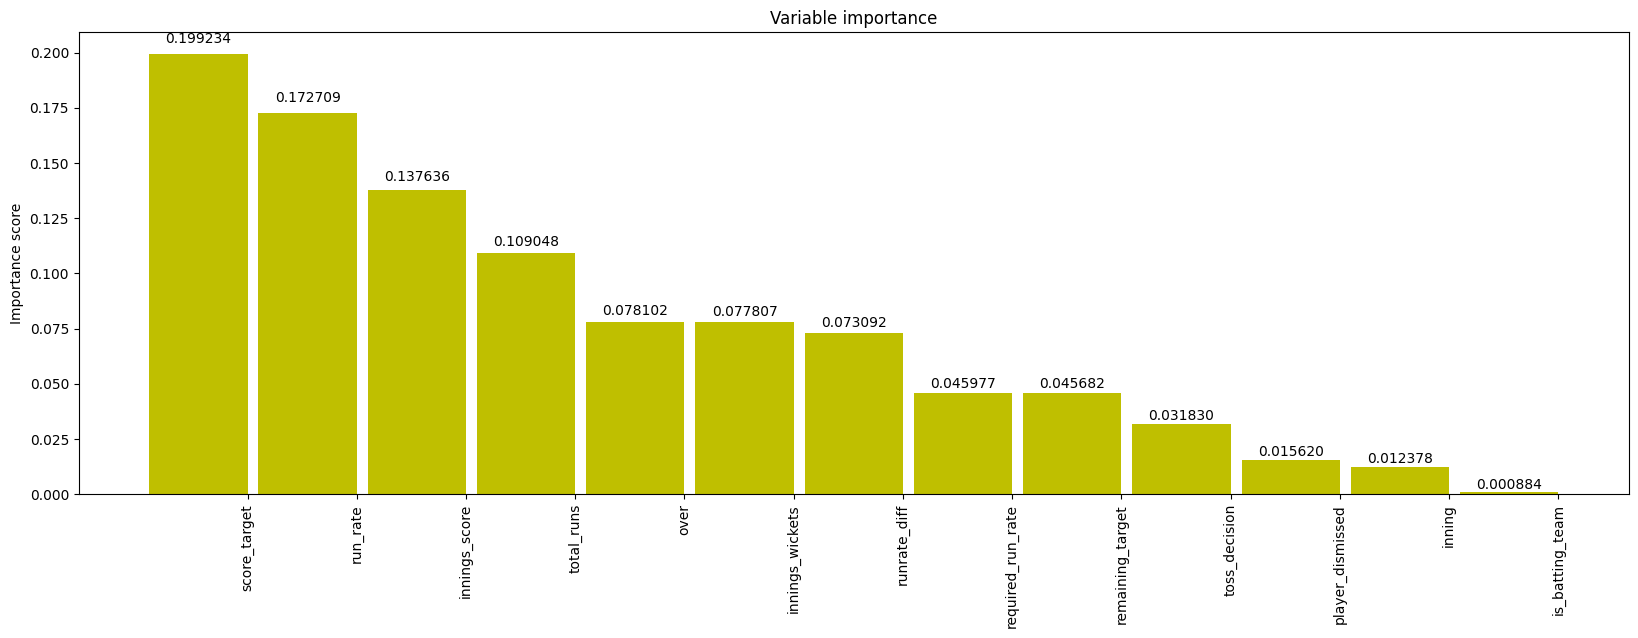

In [17]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\tq\n'.format(feat))
    outfile.close()

create_feature_map(x_cols)
importance = model.get_fscore(fmap='xgb.fmap')
feature_names = [line.split('\t')[0] for line in open('xgb.fmap')]
importance = {feature_names[int(k[1:])]:v for k,v in importance.items()}
importance = sorted(importance.items(), key=operator.itemgetter(1), reverse=True)
imp_df = pd.DataFrame(importance, columns=['feature','fscore'])
imp_df['fscore'] = imp_df['fscore'] / imp_df['fscore'].sum()

# create a function for labeling #
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.02*height,
                '%f' % float(height),
                ha='center', va='bottom')
         
labels = np.array(imp_df.feature.values)
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(20,6))
rects = ax.bar(ind, np.array(imp_df.fscore.values), width=width, color='y')
ax.set_xticks(ind+((width)/2.))
ax.set_xticklabels(labels, rotation='vertical')
ax.set_ylabel("Importance score")
ax.set_title("Variable importance")
autolabel(rects)
plt.show()

**Run rate** is the most important predictor of the win. It makes sense since if the run rate is high, the team have higher tendency to win.

**Innings score** is the second most important predictor with **target score** being the third.

**Win probability at the end of each over for SRH:**

Now that we had a look at the important predictor variables, let us check the win probability predictions for the final match.

In [18]:
preds

array([0.23164214, 0.4621921 , 0.7158908 , 0.6509528 , 0.5950105 ,
       0.45095348, 0.4503881 , 0.18326284, 0.16601941, 0.42629796,
       0.58579296, 0.6472319 , 0.30520475, 0.1575311 , 0.31285018,
       0.34809402, 0.36052758, 0.58909065, 0.28944936, 0.34113866,
       0.18628967, 0.22051163, 0.19365321, 0.22369671, 0.13914032,
       0.13487166, 0.10598041, 0.11033341, 0.09136989, 0.09026394,
       0.21791719, 0.23599738, 0.27671057, 0.24023615, 0.3021166 ,
       0.36549857, 0.20125628, 0.11073146, 0.01587884], dtype=float32)

In [19]:
val_df.head()

,match_id,inning,toss_decision,toss_winner,over,team1,team2,batting_team,winner,total_runs,player_dismissed,innings_wickets,innings_score,score_target,remaining_target,run_rate,required_run_rate,runrate_diff,is_batting_team,target
2278,11415,1,1,Mumbai Indians,1,Mumbai Indians,Chennai Super Kings,Mumbai Indians,Mumbai Indians,2,0,0,2,-1.0,-1.0,2.000000,-1.0,-1.0,1,1
2279,11415,1,1,Mumbai Indians,2,Mumbai Indians,Chennai Super Kings,Mumbai Indians,Mumbai Indians,8,0,0,10,-1.0,-1.0,5.000000,-1.0,-1.0,1,1
2280,11415,1,1,Mumbai Indians,3,Mumbai Indians,Chennai Super Kings,Mumbai Indians,Mumbai Indians,21,0,0,31,-1.0,-1.0,10.333333,-1.0,-1.0,1,1
2281,11415,1,1,Mumbai Indians,4,Mumbai Indians,Chennai Super Kings,Mumbai Indians,Mumbai Indians,7,0,0,38,-1.0,-1.0,9.500000,-1.0,-1.0,1,1
2282,11415,1,1,Mumbai Indians,5,Mumbai Indians,Chennai Super Kings,Mumbai Indians,Mumbai Indians,8,1,1,46,-1.0,-1.0,9.200000,-1.0,-1.0,1,1


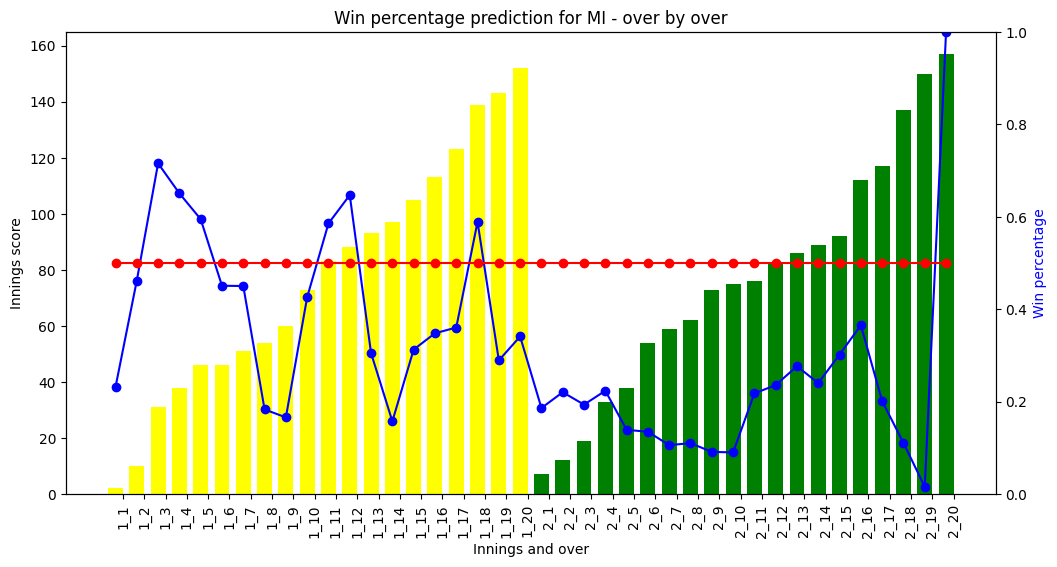

In [33]:
out_df = pd.DataFrame({'Team1':val_df.team1.values}) #mumbai indians for colab data
out_df['is_batting_team'] = val_df.is_batting_team.values
out_df['Team2'] = val_df.team2.values
out_df['innings_over'] = np.array(val_df.apply(lambda row: str(row['inning']) + "_" + str(row['over']), axis=1))
out_df['innings_score'] = val_df.innings_score.values
out_df['innings_wickets'] = val_df.innings_wickets.values
out_df['score_target'] = val_df.score_target.values
out_df['total_runs'] = val_df.total_runs.values
out_df['predictions'] = list(preds)+[1]
out_df['run_rate'] = val_df.run_rate.values
out_df['wickets_in_over'] = val_df.player_dismissed.values
out_df['required_run_rate'] = val_df.required_run_rate.values

fig, ax1 = plt.subplots(figsize=(12,6))
ax2 = ax1.twinx()
labels = np.array(out_df['innings_over'])
ind = np.arange(len(labels))
width = 0.7
rects = ax1.bar(ind, np.array(out_df['innings_score']), width=width, color=['yellow']*20 + ['green']*20)
ax1.set_xticks(ind+((width)/2.))
ax1.set_xticklabels(labels, rotation='vertical')
ax1.set_ylabel("Innings score")
ax1.set_xlabel("Innings and over")
ax1.set_title("Win percentage prediction for MI - over by over")

ax2.plot(ind, np.array(out_df['predictions']), color='b', marker='o')
ax2.plot(ind, np.array([0.5]*len(out_df['predictions'])), color='red', marker='o')
ax2.set_ylabel("Win percentage", color='b')
ax2.set_ylim([0,1])
ax2.grid(False)
plt.show()

Yellow bar represents the scores in the corresponding overs played by MI while green is for CSK. 

Red line represents the equal win probability and blue line represents the win probability of MI at the end of each over. 

As we can see, it was generally above 0.5 for most part of the first innings, and down for first few overs in second innings but things changed in the last over.

So let us look at the same graph by using the number of runs scored in that over in place of overall runs.

In [34]:
val_df.head()

,match_id,inning,toss_decision,toss_winner,over,team1,team2,batting_team,winner,total_runs,player_dismissed,innings_wickets,innings_score,score_target,remaining_target,run_rate,required_run_rate,runrate_diff,is_batting_team,target
2278,11415,1,1,Mumbai Indians,1,Mumbai Indians,Chennai Super Kings,Mumbai Indians,Mumbai Indians,2,0,0,2,-1.0,-1.0,2.000000,-1.0,-1.0,1,1
2279,11415,1,1,Mumbai Indians,2,Mumbai Indians,Chennai Super Kings,Mumbai Indians,Mumbai Indians,8,0,0,10,-1.0,-1.0,5.000000,-1.0,-1.0,1,1
2280,11415,1,1,Mumbai Indians,3,Mumbai Indians,Chennai Super Kings,Mumbai Indians,Mumbai Indians,21,0,0,31,-1.0,-1.0,10.333333,-1.0,-1.0,1,1
2281,11415,1,1,Mumbai Indians,4,Mumbai Indians,Chennai Super Kings,Mumbai Indians,Mumbai Indians,7,0,0,38,-1.0,-1.0,9.500000,-1.0,-1.0,1,1
2282,11415,1,1,Mumbai Indians,5,Mumbai Indians,Chennai Super Kings,Mumbai Indians,Mumbai Indians,8,1,1,46,-1.0,-1.0,9.200000,-1.0,-1.0,1,1


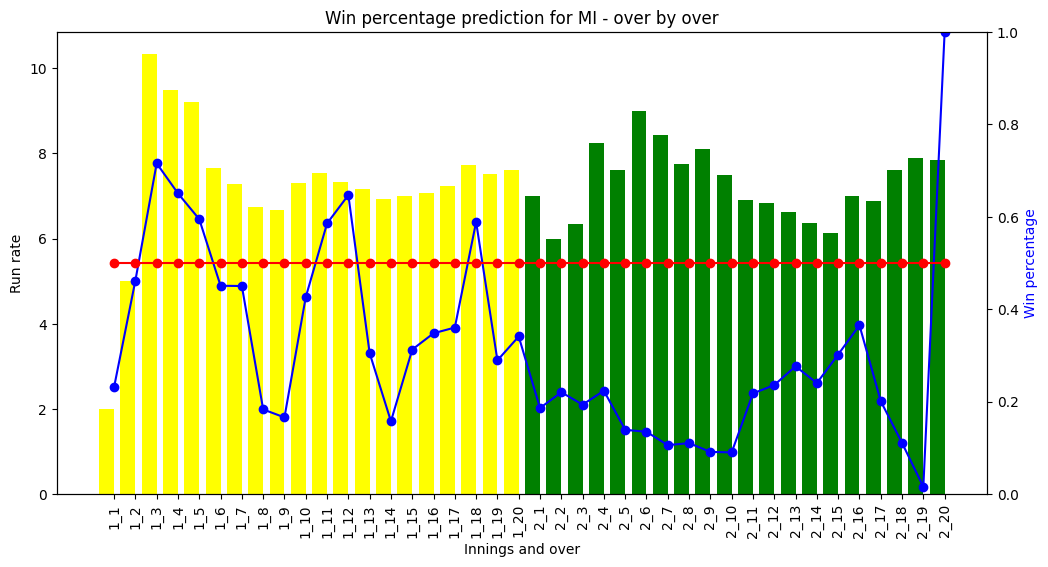

In [35]:
fig, ax1 = plt.subplots(figsize=(12,6))
ax2 = ax1.twinx()
labels = np.array(out_df['innings_over'])
ind = np.arange(len(labels))
width = 0.7
rects = ax1.bar(ind, np.array(out_df['run_rate']), width=width, color=['yellow']*20 + ['green']*20)
ax1.set_xticks(ind+((width)/2.))
ax1.set_xticklabels(labels, rotation='vertical')
ax1.set_ylabel("Run rate")
ax1.set_xlabel("Innings and over")
ax1.set_title("Win percentage prediction for MI - over by over")

ax2.plot(ind+0.35, np.array(out_df['predictions']), color='b', marker='o')
ax2.plot(ind+0.35, np.array([0.5]*len(out_df['predictions'])), color='red', marker='o')
ax2.set_ylabel("Win percentage", color='b')
ax2.set_ylim([0,1])
ax2.grid(False)
plt.show()

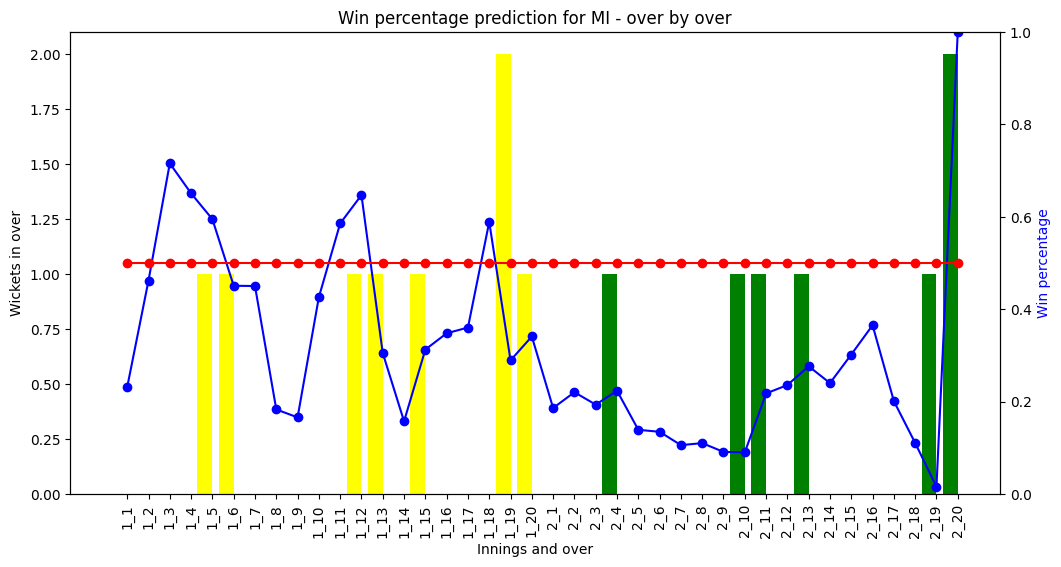

In [36]:
fig, ax1 = plt.subplots(figsize=(12,6))
ax2 = ax1.twinx()
labels = np.array(out_df['innings_over'])
ind = np.arange(len(labels))
width = 0.7
rects = ax1.bar(ind, np.array(out_df['wickets_in_over']), width=width, color=['yellow']*20 + ['green']*20)
ax1.set_xticks(ind+((width)/2.))
ax1.set_xticklabels(labels, rotation='vertical')
ax1.set_ylabel("Wickets in over")
ax1.set_xlabel("Innings and over")
ax1.set_title("Win percentage prediction for MI - over by over")

ax2.plot(ind+0.35, np.array(out_df['predictions']), color='b', marker='o')
ax2.plot(ind+0.35, np.array([0.5]*len(out_df['predictions'])), color='red', marker='o')
ax2.set_ylabel("Win percentage", color='b')
ax2.set_ylim([0,1])
ax2.grid(False)
plt.show()

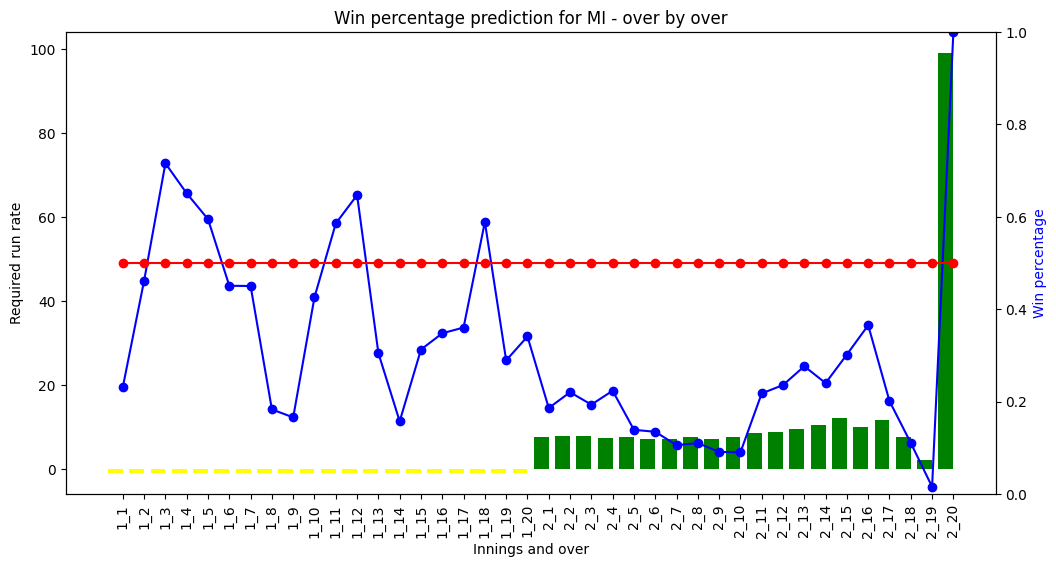

In [38]:
fig, ax1 = plt.subplots(figsize=(12,6))
ax2 = ax1.twinx()
labels = np.array(out_df['innings_over'])
ind = np.arange(len(labels))
width = 0.7
rects = ax1.bar(ind, np.array(out_df['required_run_rate']), width=width, color=['yellow']*20 + ['green']*20)
ax1.set_xticks(ind+((width)/2.))
ax1.set_xticklabels(labels, rotation='vertical')
ax1.set_ylabel("Required run rate")
ax1.set_xlabel("Innings and over")
ax1.set_title("Win percentage prediction for MI - over by over")

ax2.plot(ind+0.35, np.array(out_df['predictions']), color='b', marker='o')
ax2.plot(ind+0.35, np.array([0.5]*len(out_df['predictions'])), color='red', marker='o')
ax2.set_ylabel("Win percentage", color='b')
ax2.set_ylim([0,1])
ax2.grid(False)
plt.show()

In [20]:
# save and load the model to a pickle file
import pickle
pickle.dump(model, open("model.pkl", "wb"))